<a href="https://colab.research.google.com/github/damola936/AI-ML-LLM/blob/main/FoodVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision Project

### Check GPU (Mixed Precision Training)
Not all GPUs are compatible with mixed precision training. In order too use mized precision training we need a GPU with computation score of 7.0+

In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


### Get Helper Functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-02-06 10:52:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-02-06 10:52:10 (108 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



In [ ]:
# Importing Helper functions we are going to use in this notebook
from helper_functions import plot_loss_curves, unzip_data, walk_through_dir, compare_historys

In [ ]:
# Create a function to load and prepare images
import tensorflow as tf

def load_prep_image(filepath, img_shape=224, scale=True):
    """
        Reads in an image and preprocesses it for model prediction

        Args:
            filepath (str): path to target image
            img_shape (int): shape to resize image to. Default = 224
            scale (bool): Condition to scale image. Default = True

        Returns:
            Image Tensor of shape (img_shape, img_shape, 3)
    """
    image = tf.io.read_file(filepath)
    image_tensor = tf.io.decode_image(image, channels=3)
    image_tensor = tf.image.resize(image_tensor, [img_shape, img_shape])
    if scale:
        scaled_image_tensor = image_tensor / 255. # If model doesnt have bult in scaling
        return scaled_image_tensor
    else:
        return image_tensor

In [ ]:
# Copy and paste plot_confusion_matrix here, make changes to make the xticks 90degrees
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Rotate to 90 degrees
  plt.xticks(rotation=90, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

### Importing the Dataset (Using TensorFlow Datasets)

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
datasets = tfds.list_builders() # Get all availiable datasets
print("food101" in datasets)

True


In [ ]:
# Loading the dataset (5-6 Minutes)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, with_info=True) # Data Labels Get returned in tuple format

### Data Exploration
- class names
- Image Tensor shape
- datatype of data
- Nature of Labels. OneHotEncoded?
- Do labels and class names match

In [ ]:
# Get the features of the dataset
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Get Dataset info
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Get the shape
# Take one sample of train data
train_one_sample = train_data.take(1) # samples are in format(image_tensor, label)

In [ ]:
# Nature of one sample of our training data
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about training sample
for image, label in train_one_sample:
    print(f"""
        Image shape:{image.shape} Image datatype:{image.dtype} Target Class:{label}
          Class name: {class_names[label.numpy()]}
    """)


        Image shape:(512, 512, 3) Image datatype:<dtype: 'uint8'> Target Class:64
          Class name: miso_soup
    


In [ ]:
# Since datatype is uint8, what does that look like
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 43,  89, 125],
        [ 52,  96, 131],
        [ 85, 128, 162],
        ...,
        [251, 254, 223],
        [250, 253, 222],
        [250, 253, 222]],

       [[ 42,  88, 124],
        [ 53,  97, 132],
        [ 92, 135, 169],
        ...,
        [251, 254, 223],
        [250, 253, 222],
        [250, 253, 222]],

       [[ 45,  89, 124],
        [ 52,  96, 131],
        [ 92, 135, 169],
        ...,
        [251, 254, 223],
        [250, 253, 222],
        [250, 253, 222]],

       ...,

       [[ 91,  99,  86],
        [ 89,  97,  84],
        [ 88,  94,  82],
        ...,
        [ 37,  44,  50],
        [ 34,  41,  47],
        [ 31,  38,  44]],

       [[ 91,  99,  86],
        [ 90,  98,  85],
        [ 88,  96,  83],
        ...,
        [ 38,  43,  47],
        [ 35,  40,  44],
        [ 33,  38,  42]],

       [[ 93, 101,  88],
        [ 93, 101,  88],
        [ 89,  97,  84],
        ...,
        [ 37,  42,  4

In [ ]:
# What are the minimum and maximum values of our image tensor
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

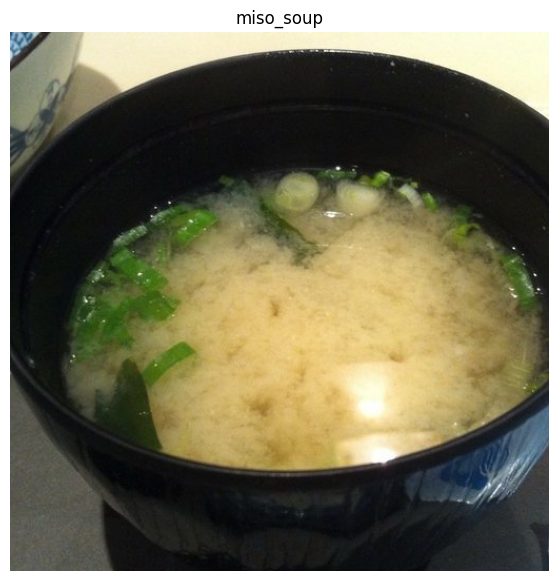

In [ ]:
# Plot Image
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to verify label
plt.axis("off")
plt.show()

### Preprocessing the Images

Neural networks perform best when data is normalized and in batches. Not all data from tensorflow datasets come like this

In order to get data ready for a neural network we have to write preprocessing functions and map it to the data.

> - data is in `uint8`
- Images are different sizes
- Not scaled

TO DO:

Neural Network needs data in
> - Data in `float32`
- Data in batches
- Normalized. We dont need to as we are using `EfficientNet`.

In [ ]:
# Preprocess data function
def preprocess_image(image, label, img_shape=224):
    """
        converts image tensor datatype to float32 and reshapes
        image to (img_shape, img_shape, color_channels)

        Args:
            image(list): A Tensorflow image tensor
            label(int): Class Label of the Image.(Not one hot encoded)
            img_shpa(int): Output shape of the expected image

        returns:
            A preprocessed image tensor of
             datatype float32 and shape(img_shape, img_shape, color_channels)

    """
    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image, tf.float32), label # return a tuple of (float32_image, label)

In [ ]:
# Preprocess a single sample
preprocessed_image = preprocess_image(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}... \nShape{image.shape}, \nDatatype:{image.dtype}")
print(f"Image after preprocessing:\n {preprocessed_image[:2]}... \nShape{preprocessed_image.shape}, \nDatatype:{preprocessed_image.dtype}")

Image before preprocessing:
 [[[ 43  89 125]
  [ 52  96 131]
  [ 85 128 162]
  ...
  [251 254 223]
  [250 253 222]
  [250 253 222]]

 [[ 42  88 124]
  [ 53  97 132]
  [ 92 135 169]
  ...
  [251 254 223]
  [250 253 222]
  [250 253 222]]]... 
Shape(512, 512, 3), 
Datatype:<dtype: 'uint8'>
Image after preprocessing:
 [[[ 48.969387  93.68367  129.04082 ]
  [124.78572  164.07144  195.28572 ]
  [125.37245  158.94388  183.5153  ]
  ...
  [251.78574  254.78574  223.78574 ]
  [251.       254.       223.      ]
  [250.       253.       222.      ]]

 [[ 65.28572  108.688774 143.09183 ]
  [129.93878  169.09184  200.17348 ]
  [ 79.61224  115.04081  140.88266 ]
  ...
  [251.78574  254.78574  223.78574 ]
  [251.       254.       223.      ]
  [250.       253.       222.      ]]]... 
Shape(224, 224, 3), 
Datatype:<dtype: 'float32'>


#### Batch & prepare datasets

Map `preprocess_image( )` function to our train data. Shuffle a number of elements and batch it in `32's` and finally make sure you prepare new batches `.prefetch( )` whilst the model is looking for patterns on the current batch

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Map preprocessing function to training and parallelize it
train_data = train_data.map(map_func=preprocess_image,
                            num_parallel_calls=tf.data.AUTOTUNE) # Use all avilable CPUs

# Shuffle train data, turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(
    buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data(No shuffle on our Test data), turn it into batches and prefetch it
test_data = test_data.map(map_func=preprocess_image,
                           num_parallel_calls=tf.data.AUTOTUNE
                           ).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
# Get first batch (images, labels)
first_batch = next(iter(test_data))  # Extracts the first batch
images, labels = first_batch  # Unpack images and labels

# Convert labels to numpy and print first 5
first_5_labels = labels.numpy()[:5]
print("First 5 labels:", first_5_labels)

First 5 labels: [84 60 29 80 32]


In [ ]:
# Convert labels to class names
first_5_class_names = [class_names[label] for label in first_5_labels]
print("First 5 class names:", first_5_class_names)

First 5 class names: ['risotto', 'lobster_bisque', 'cup_cakes', 'pulled_pork_sandwich', 'dumplings']


### Create Callbacks
> - `TensorBoard Callbacks`, for later visualization
- `ModelCheckpoint callback`, to save our Model's progress after feature extraction
- `Early Stopping Callback`, to stop fine tuning when model does not improve

In [ ]:
import datetime
import tensorflow as tf

# Create a tensorboard callback
def create_tensorboard_callback(dir_name, experiment_name):
    """
        Creates a tensorboard callback to use when training
    """
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y-%m-%d <-> %H-%M-%S")
    file_writer = tf.summary.create_file_writer(log_dir) # Create a FileWriter for TensorBoard
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [ ]:
# Create Checkpoint callback

# Make a Checkpoint Path
checkpoint_path  = "FoodVision_weights/checkpoint.weights.h5" # Must end in .weights.h5

# Create a ModelCheckpoint callback for model 4 that saves model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, save_weights_only=True,
    save_best_only=True, save_freq="epoch", # save every epoch
    verbose=1, monitor="val_accuracy"
)

In [ ]:
# Create EarlyStopping Callback

### Model Training using Mixed Precision Training

>Mixed precision utilizes a combination of `float32` and `float16` data types to speed up Model performance

#### Setting up mixed precision policy

In [ ]:
from tensorflow.keras import mixed_precision

# Setting up Mixed Precision data policy to mixed precision
mixed_precision.set_global_policy("mixed_float16")

#### Building Feature Extraction Model

In [ ]:
from tensorflow.keras import layers
# from tensorflow.keras.layers import preprocessing
import tensorflow as tf

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")

# If model does not have rescaling built in use
# x = preprocessing.Rescaling(1./255)(x)

x = base_model(inputs, training=False)

x = layers.GlobalAveragePooling2D(name="global_average_poolingg_layer")(x)

x = layers.Dense(len(class_names), name="dense_logits")(x)

outputs = layers.Activation("softmax", name="predictions", dtype=tf.float32)(x)

model = tf.keras.Model(inputs, outputs)
optimizer = mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam())

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=optimizer, metrics=["accuracy"])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_poolingg_layer        │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_logits (Dense)                 │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Activation)             │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
for layer in model.layers:
    print(layer.dtype)

float32
float32
float32
float32
float32


In [ ]:
history = model.fit(train_data, epochs=5, validation_data=test_data,
          validation_steps=int(0.15 * len(test_data)), callbacks=[
              create_tensorboard_callback("FoodVision", "FeatureExtraction"),
              checkpoint_callback
          ])

Saving TensorBoard log files to: FoodVision/FeatureExtraction/2025-02-06 <-> 10-52-15
Epoch 1/5
 510/2368 ━━━━━━━━━━━━━━━━━━━━ 3:37:59 7s/step - accuracy: 0.3013 - loss: 3.2473

In [ ]:
result = model.evaluate(test_data)
result

In [ ]:
plot_loss_curves(history)

### Fine Tuning

In [ ]:
model.load_weights(checkpoint_path)

base_model.trainable = True

for layer in base_model.layers[:-5]: # Freeze all layers except the last 5
    layer.trainable = False


# Recompile the Model
optimizer = mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=0.0001)) # Reduce the learning rate to reduce overfitting

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=optimizer, metrics=["accuracy"])

# fit the Model again
history_tuned = model.fit(train_data, epochs=10, initial_epoch=history.epoch[-1], validation_data=test_data,
                          validation_steps=int(0.15 * len(test_data)), callbacks=[create_tensorboard_callback("FoodVision", "FineTuning")])

In [ ]:
tuned_result = model.evaluate(test_data)

In [ ]:
compare_historys(history, history_tuned)

### Save and Reload Model

In [ ]:
import warnings

warnings.filterwarnings("ignore")
model.save("drive/MyDrive/FoodVision.keras")

In [ ]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/FoodVision.keras")
loaded_model_results = loaded_model.evaluate(test_data)
print(f"Original Model results: {result}")
print(f"Fine Tuned Model Results: {loaded_model_results}")

### Make predictions

In [ ]:
pred_probs = loaded_model.predict(test_data, verbose=1)

In [ ]:
pred_labels = np.argmax(pred_probs, axis=1)

In [ ]:
y_labels = np.concatenate([labels.numpy() for _, labels in test_data])

In [ ]:
print(pred_labels[:10])
print(y_labels[:10])

[37 90 94 16 40 60 13 96 46 21]
[90 33  9 12 78 77 96  6 48  9]


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_labels, pred_labels)
accuracy

0.01005940594059406

In [ ]:
pred_labels_real = [class_names[i] for i in pred_labels]
y_labels_real = [class_names[i]  for i in y_labels]
print(pred_labels_real[:10])
print(y_labels_real[:10])

['filet_mignon', 'spaghetti_bolognese', 'strawberry_shortcake', 'cheesecake', 'french_fries', 'lobster_bisque', 'caprese_salad', 'tacos', 'garlic_bread', 'chocolate_cake']
['spaghetti_bolognese', 'edamame', 'breakfast_burrito', 'cannoli', 'poutine', 'pork_chop', 'tacos', 'beignets', 'greek_salad', 'breakfast_burrito']
